In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Tokenization took: 26.63 ms
Type conversion took: 48.63 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 15.81 ms
Type conversion took: 44.32 ms
Parser memory cleanup took: 0.01 ms
Shape of the data with all features: (109400, 11)
Shape of the data with numerical features: (109400, 11)
List of features contained our dataset: ['type', 'price', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'number_of_rooms', 'floor_number', 'number_of_floors', 'building_type']
Shape of the data with numerical features: (63533, 11)
Shape of the data with numerical features: (27180, 11)


In [2]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )



Errors on the test set
mean square:      699118839564.7357
mean absolute:    253308.0210799522
median_absolute:  77543.66666666674


threshold =   2.5, good =      14128, bad =      13052, err = 0.480206033848418
threshold =   5.0, good =      19903, bad =       7277, err = 0.2677336276674025
threshold =  10.0, good =      23910, bad =       3270, err = 0.12030905077262694


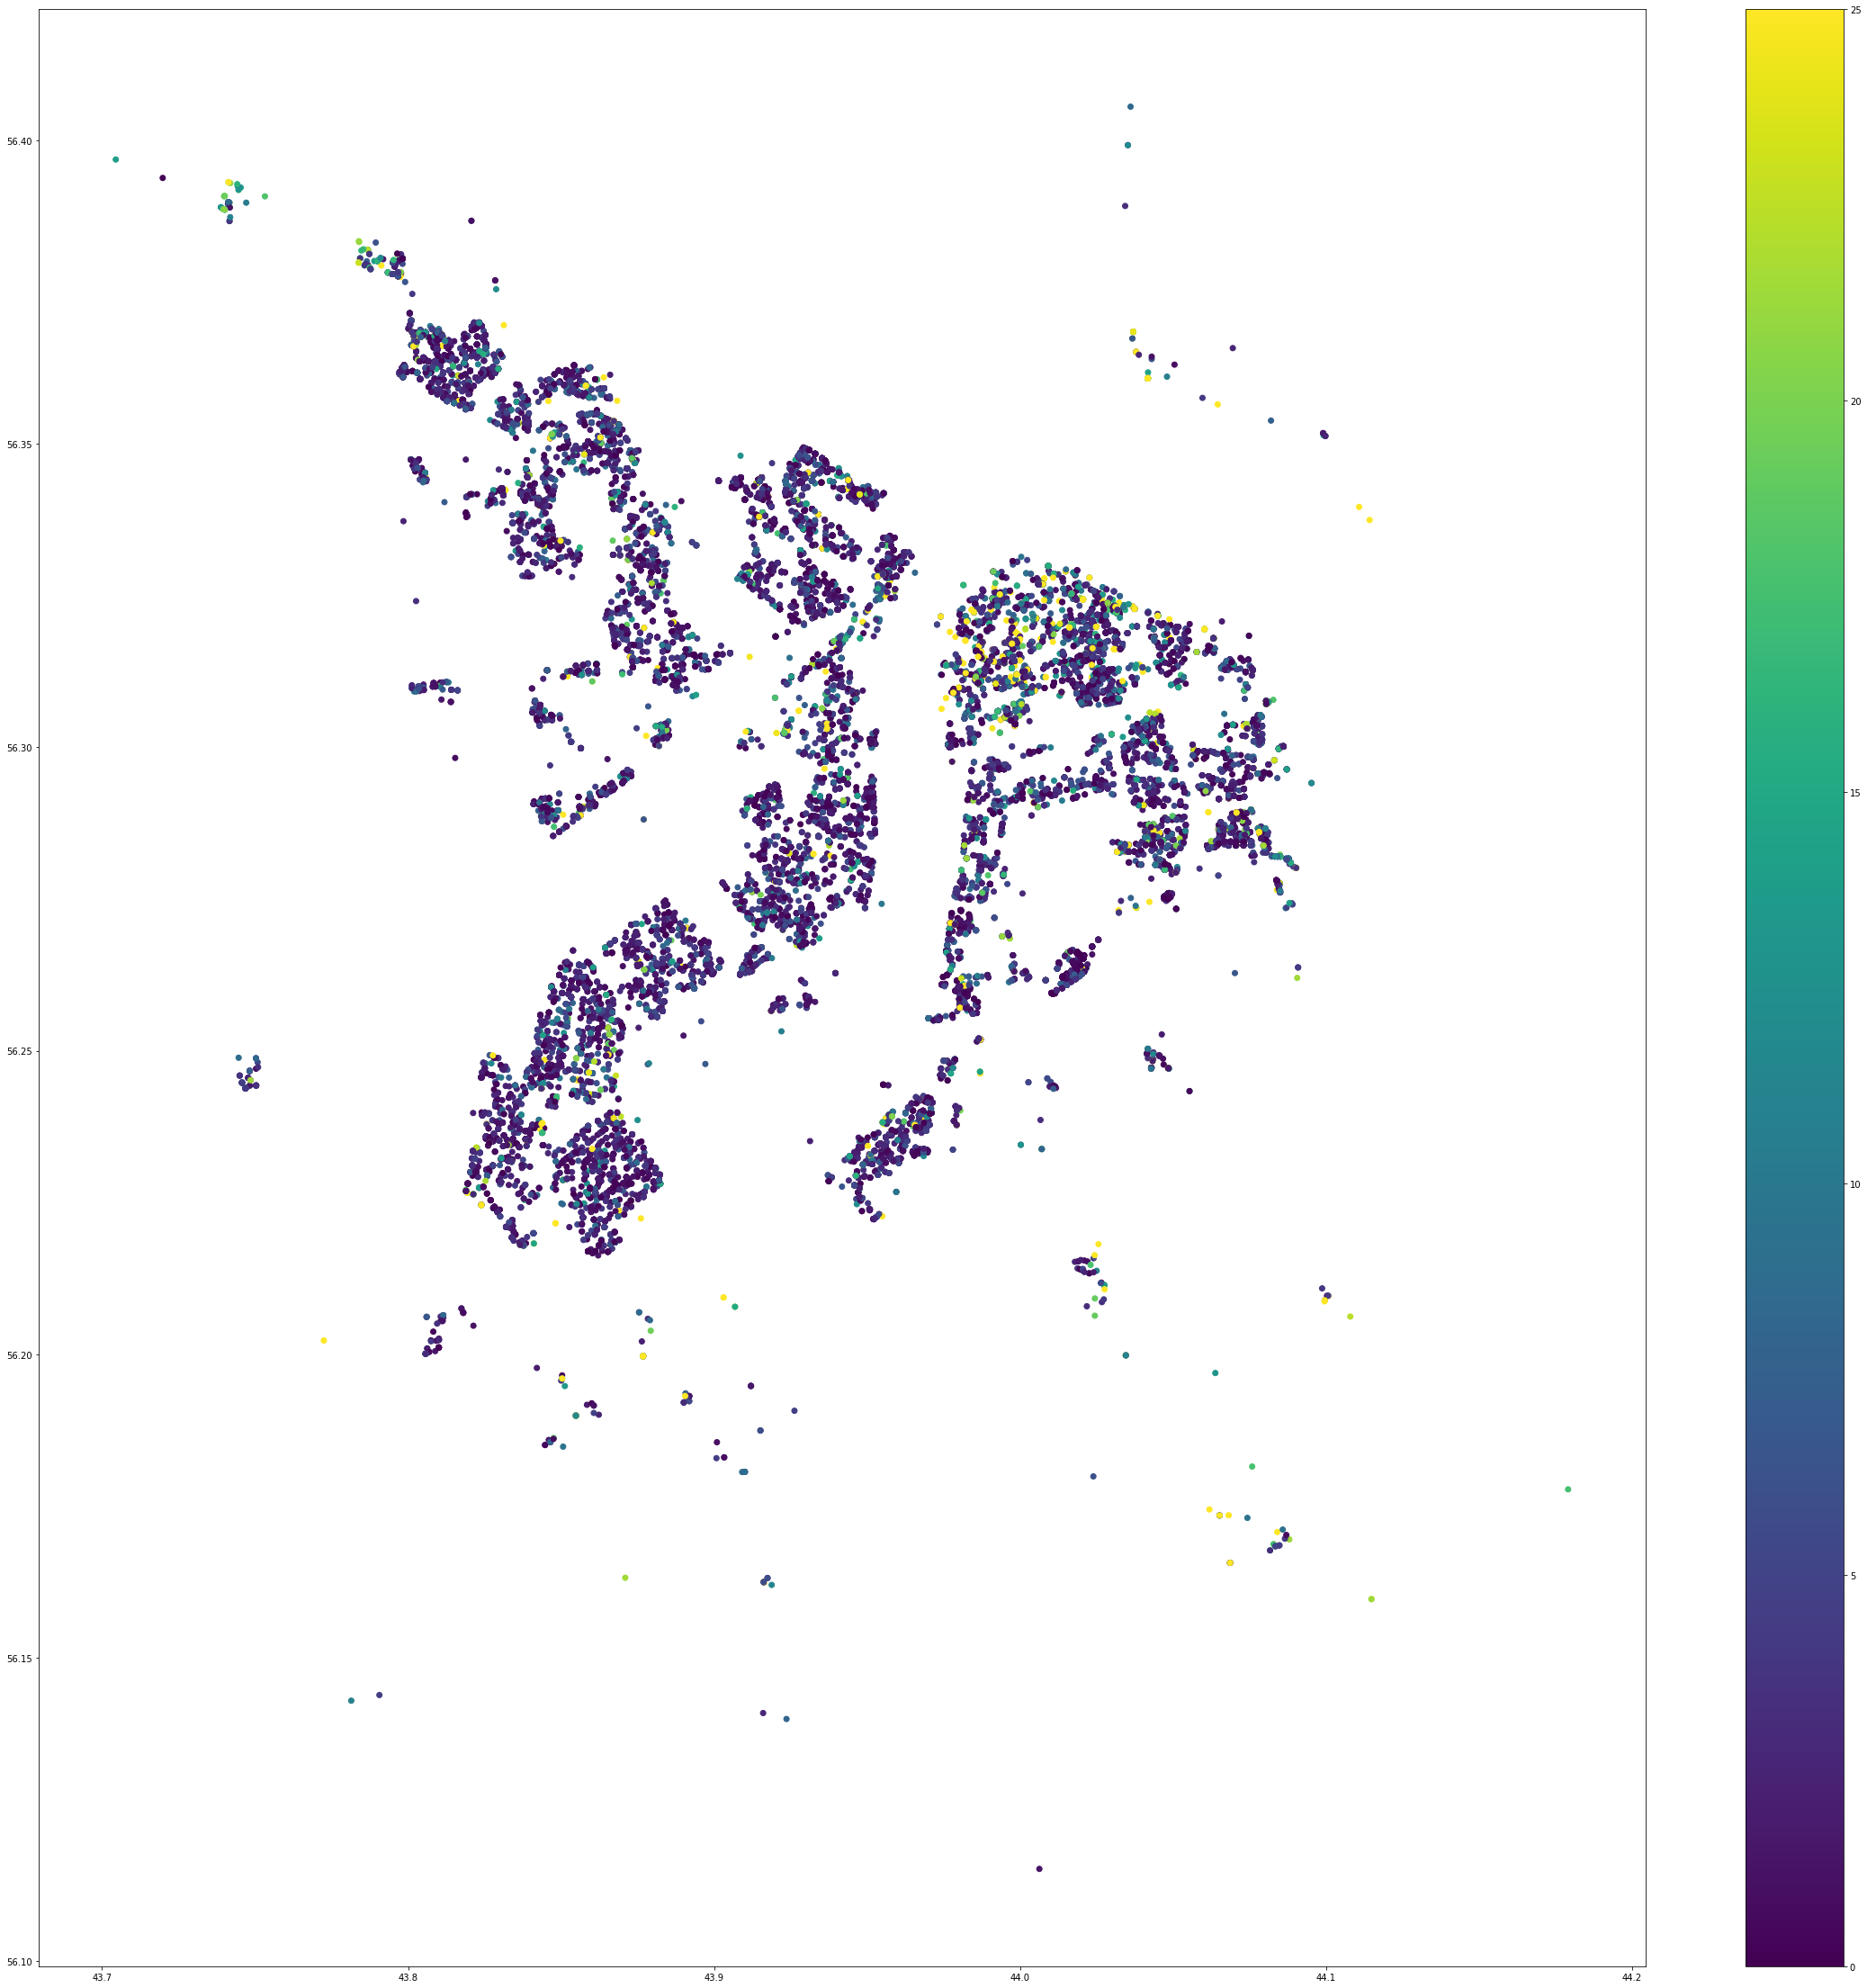

In [3]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 25 );

plt.figure(figsize=(40,40))

plt.scatter (x, y, c=c,  )
plt.colorbar()
plt.show    ()

In [4]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.01
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.01
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                 Вторичка
price                2.85e+06
longitude              44.006
latitude              56.3269
total_square               94
living_square              64
kitchen_square              9
number_of_rooms             4
floor_number                2
number_of_floors            3
building_type       Кирпичный
Name: 63395, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude              44.006
latitude              56.3269
total_square             43.7
living_square            27.6
kitchen_square            7.5
number_of_rooms             2
floor_number                9
number_of_floors            9
building_type       Панельный
Name: 406, dtype: object
CLOSEST record
type                  Вторичка
price                 4.57e+06
longitude               44.006
latitude               56.3269
total_square                61
living_square             33.1
kitchen_square              11
number_of_rooms              

CLOSEST record
type                Новостройка
price                   4.8e+06
longitude                44.006
latitude                56.3269
total_square              76.99
living_square             46.96
kitchen_square             11.3
number_of_rooms               3
floor_number                  7
number_of_floors              8
building_type                  
Name: 9619, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              49
living_square             28
kitchen_square           9.5
number_of_rooms            2
floor_number               8
number_of_floors           9
building_type               
Name: 9712, dtype: object
CLOSEST record
type                   Вторичка
price               5.78934e+06
longitude                44.006
latitude                56.3269
total_square               91.1
living_square              46.8
kitchen_square             15.4
number_o

CLOSEST record
type                 Вторичка
price                2.45e+06
longitude              44.006
latitude              56.3269
total_square             39.6
living_square              27
kitchen_square              6
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 15782, dtype: object
CLOSEST record
type                 Вторичка
price                7.65e+06
longitude              44.006
latitude              56.3269
total_square             74.5
living_square              38
kitchen_square             11
number_of_rooms             2
floor_number                6
number_of_floors           10
building_type       Кирпичный
Name: 15801, dtype: object
CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square             27
kitchen_square             6
number_of_rooms            2
floor_num

CLOSEST record
type                Вторичка
price               3.55e+06
longitude             44.006
latitude             56.3269
total_square              55
living_square             31
kitchen_square           8.5
number_of_rooms            2
floor_number               7
number_of_floors           9
building_type               
Name: 23276, dtype: object
CLOSEST record
type                Вторичка
price                2.6e+06
longitude            44.0079
latitude             56.3279
total_square              76
living_square             52
kitchen_square            10
number_of_rooms            5
floor_number               2
number_of_floors           4
building_type               
Name: 23306, dtype: object
CLOSEST record
type                Вторичка
price                4.7e+06
longitude             44.006
latitude             56.3269
total_square            67.9
living_square           41.6
kitchen_square           9.5
number_of_rooms            3
floor_number               8
nu

CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square             39.9
living_square            24.7
kitchen_square            6.3
number_of_rooms             2
floor_number                7
number_of_floors            9
building_type       Кирпичный
Name: 33463, dtype: object
CLOSEST record
type                 Вторичка
price                8.35e+06
longitude              44.006
latitude              56.3269
total_square             92.3
living_square              60
kitchen_square           13.5
number_of_rooms             3
floor_number                2
number_of_floors           10
building_type       Кирпичный
Name: 33476, dtype: object
CLOSEST record
type                 Вторичка
price                1.01e+07
longitude              44.006
latitude              56.3269
total_square              116
living_square              79
kitchen_square             15
number_of_rooms             3
f

CLOSEST record
type                Вторичка
price                  3e+06
longitude            44.0078
latitude             56.3255
total_square              45
living_square             30
kitchen_square             7
number_of_rooms            2
floor_number               3
number_of_floors           3
building_type               
Name: 45232, dtype: object
CLOSEST record
type                 Вторичка
price                2.85e+06
longitude              44.006
latitude              56.3269
total_square             43.7
living_square            27.6
kitchen_square            7.1
number_of_rooms             2
floor_number                8
number_of_floors            9
building_type       Панельный
Name: 45506, dtype: object
CLOSEST record
type                Вторичка
price                6.5e+06
longitude            44.0027
latitude             56.3249
total_square            66.3
living_square             45
kitchen_square             6
number_of_rooms            2
floor_number        

Name: 58978, dtype: object
CLOSEST record
type                 Вторичка
price                 3.5e+06
longitude              44.006
latitude              56.3269
total_square             63.9
living_square            38.6
kitchen_square            9.1
number_of_rooms             3
floor_number                8
number_of_floors            9
building_type       Панельный
Name: 58979, dtype: object
CLOSEST record
type                 Вторичка
price                 3.1e+06
longitude              44.006
latitude              56.3269
total_square             68.1
living_square            45.9
kitchen_square            6.3
number_of_rooms             3
floor_number                2
number_of_floors            4
building_type       Кирпичный
Name: 59611, dtype: object
CLOSEST record
type                 Вторичка
price                 4.8e+06
longitude              44.006
latitude              56.3269
total_square             64.2
living_square              46
kitchen_square            8.2
numb

CLOSEST record
type                 Вторичка
price                1.46e+06
longitude              44.006
latitude              56.3269
total_square             35.7
living_square              25
kitchen_square            4.7
number_of_rooms             2
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 75621, dtype: object
CLOSEST record
type                 Вторичка
price                 4.2e+06
longitude              44.006
latitude              56.3269
total_square             67.3
living_square            39.2
kitchen_square              7
number_of_rooms             3
floor_number                9
number_of_floors            9
building_type       Кирпичный
Name: 75624, dtype: object
CLOSEST record
type                 Вторичка
price                 2.3e+06
longitude              44.006
latitude              56.3269
total_square               45
living_square              31
kitchen_square              6
number_of_rooms             2
f

CLOSEST record
type                Вторичка
price                  6e+06
longitude            44.0027
latitude             56.3249
total_square              57
living_square             35
kitchen_square             5
number_of_rooms            2
floor_number               3
number_of_floors           5
building_type               
Name: 87430, dtype: object
CLOSEST record
type                 Вторичка
price                1.99e+07
longitude              44.006
latitude              56.3269
total_square            225.7
living_square           122.1
kitchen_square           21.8
number_of_rooms             5
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 87997, dtype: object
CLOSEST record
type                Вторичка
price                4.2e+06
longitude             44.006
latitude             56.3269
total_square            68.8
living_square           31.7
kitchen_square          14.5
number_of_rooms            2
floor_number        

CLOSEST record
type                Вторичка
price                2.6e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square           26.3
kitchen_square             6
number_of_rooms            2
floor_number               2
number_of_floors           5
building_type               
Name: 96284, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            62.2
living_square           42.6
kitchen_square             7
number_of_rooms            3
floor_number               2
number_of_floors           9
building_type               
Name: 96400, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square               38
living_square              27
kitchen_square            5.5
number_of_rooms             2
floor_number           

CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude              44.006
latitude              56.3269
total_square             43.7
living_square            27.6
kitchen_square            7.5
number_of_rooms             2
floor_number                9
number_of_floors            9
building_type       Панельный
Name: 406, dtype: object
CLOSEST record
type                  Вторичка
price                 4.57e+06
longitude               44.006
latitude               56.3269
total_square                61
living_square             33.1
kitchen_square              11
number_of_rooms              2
floor_number                13
number_of_floors            17
building_type       Монолитный
Name: 625, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square               45
living_square              28
kitchen_square              7
number_of_rooms         

CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              29
kitchen_square            5.8
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 8929, dtype: object
CLOSEST record
type                 Вторичка
price                   4e+06
longitude              44.006
latitude              56.3269
total_square               68
living_square              44
kitchen_square            7.5
number_of_rooms             3
floor_number                5
number_of_floors            9
building_type       Панельный
Name: 8931, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square               63
living_square            43.9
kitchen_square            7.1
number_of_rooms             3
flo

CLOSEST record
type                 Вторичка
price                2.45e+06
longitude              44.006
latitude              56.3269
total_square             39.6
living_square              27
kitchen_square              6
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 15782, dtype: object
CLOSEST record
type                 Вторичка
price                7.65e+06
longitude              44.006
latitude              56.3269
total_square             74.5
living_square              38
kitchen_square             11
number_of_rooms             2
floor_number                6
number_of_floors           10
building_type       Кирпичный
Name: 15801, dtype: object
CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square             27
kitchen_square             6
number_of_rooms            2
floor_num

CLOSEST record
type                Вторичка
price                6.8e+06
longitude            44.0083
latitude             56.3251
total_square              84
living_square             40
kitchen_square            30
number_of_rooms            3
floor_number               3
number_of_floors           5
building_type               
Name: 24689, dtype: object
CLOSEST record
type                Вторичка
price               4.55e+06
longitude             44.006
latitude             56.3269
total_square              69
living_square             35
kitchen_square            11
number_of_rooms            2
floor_number              17
number_of_floors          17
building_type               
Name: 25313, dtype: object
CLOSEST record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square              70
living_square           44.7
kitchen_square           8.5
number_of_rooms            3
floor_number               9
nu

CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square           32.8
kitchen_square           5.5
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 39567, dtype: object
CLOSEST record
type                 Вторичка
price                 4.2e+06
longitude              44.006
latitude              56.3269
total_square             62.5
living_square              38
kitchen_square            9.2
number_of_rooms             3
floor_number                2
number_of_floors            5
building_type       Панельный
Name: 40238, dtype: object
CLOSEST record
type                 Вторичка
price                1.99e+06
longitude              44.006
latitude              56.3269
total_square             44.3
living_square              30
kitchen_square              6
number_of_rooms             2
floor_number

Name: 56344, dtype: object
CLOSEST record
type                 Вторичка
price                 4.1e+06
longitude              44.006
latitude              56.3269
total_square             77.3
living_square              44
kitchen_square           10.5
number_of_rooms             3
floor_number                9
number_of_floors            9
building_type       Панельный
Name: 56346, dtype: object
CLOSEST record
type                 Вторичка
price                 4.5e+06
longitude              44.006
latitude              56.3269
total_square             62.8
living_square            43.4
kitchen_square            7.3
number_of_rooms             3
floor_number                3
number_of_floors            9
building_type       Панельный
Name: 56350, dtype: object
CLOSEST record
type                 Вторичка
price                 4.5e+06
longitude              44.006
latitude              56.3269
total_square               63
living_square              43
kitchen_square            7.3
numb

CLOSEST record
type                 Вторичка
price                1.03e+06
longitude              44.006
latitude              56.3269
total_square               34
living_square              26
kitchen_square            5.5
number_of_rooms             2
floor_number                2
number_of_floors            2
building_type       Кирпичный
Name: 70865, dtype: object
CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square             44.3
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 70927, dtype: object
CLOSEST record
type                 Вторичка
price                3.39e+06
longitude              44.006
latitude              56.3269
total_square               63
living_square              43
kitchen_square              7
number_of_rooms             3
f

Name: 84380, dtype: object
CLOSEST record
type                 Вторичка
price                 3.4e+06
longitude              44.006
latitude              56.3269
total_square             58.4
living_square              42
kitchen_square            5.6
number_of_rooms             4
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 84399, dtype: object
CLOSEST record
type                 Вторичка
price                 6.9e+06
longitude              44.006
latitude              56.3269
total_square             83.1
living_square            45.3
kitchen_square             18
number_of_rooms             5
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 84401, dtype: object
CLOSEST record
type                  Вторичка
price                 8.35e+06
longitude               44.006
latitude               56.3269
total_square             111.1
living_square             59.5
kitchen_square              

CLOSEST record
type                 Вторичка
price                   4e+06
longitude              44.006
latitude              56.3269
total_square             55.3
living_square            30.4
kitchen_square            7.6
number_of_rooms             2
floor_number                5
number_of_floors            9
building_type       Кирпичный
Name: 93557, dtype: object
CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square               45
living_square            27.5
kitchen_square            7.5
number_of_rooms             2
floor_number                8
number_of_floors            9
building_type       Панельный
Name: 93590, dtype: object
CLOSEST record
type                 Вторичка
price                   1e+07
longitude              44.006
latitude              56.3269
total_square            115.6
living_square              69
kitchen_square             22
number_of_rooms             3
f

CLOSEST record
type                 Вторичка
price                2.55e+06
longitude              44.006
latitude              56.3269
total_square             57.9
living_square              39
kitchen_square              6
number_of_rooms             3
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 108721, dtype: object
CLOSEST record
type                 Вторичка
price                1.97e+06
longitude              44.006
latitude              56.3269
total_square               38
living_square              25
kitchen_square            5.5
number_of_rooms             2
floor_number                2
number_of_floors            3
building_type       Кирпичный
Name: 108890, dtype: object

BASE record
type                Вторичка
price                2.3e+06
longitude            44.0079
latitude             56.3279
total_square              76
living_square             52
kitchen_square            10
number_of_rooms            5
floor_num

Name: 8944, dtype: object
CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square               46
living_square            26.7
kitchen_square            5.2
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 8945, dtype: object
CLOSEST record
type                 Вторичка
price                2.35e+06
longitude              44.006
latitude              56.3269
total_square             40.2
living_square              28
kitchen_square            5.4
number_of_rooms             2
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 8948, dtype: object
CLOSEST record
type                 Вторичка
price                1.45e+06
longitude              44.006
latitude              56.3269
total_square             38.6
living_square            27.5
kitchen_square              5
number_

CLOSEST record
type                Вторичка
price               3.95e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             32
kitchen_square             9
number_of_rooms            2
floor_number              12
number_of_floors          12
building_type               
Name: 21549, dtype: object
CLOSEST record
type                Вторичка
price               1.51e+06
longitude             44.006
latitude             56.3269
total_square            36.1
living_square           26.6
kitchen_square             5
number_of_rooms            2
floor_number               4
number_of_floors           4
building_type               
Name: 21596, dtype: object
CLOSEST record
type                Вторичка
price               3.25e+06
longitude            44.0092
latitude             56.3299
total_square            49.2
living_square           28.9
kitchen_square           7.9
number_of_rooms            2
floor_number              13
nu

Name: 37351, dtype: object
CLOSEST record
type                Новостройка
price                  4.64e+06
longitude               44.0092
latitude                56.3299
total_square                 65
living_square                49
kitchen_square                9
number_of_rooms               3
floor_number                  3
number_of_floors              5
building_type                  
Name: 37824, dtype: object
CLOSEST record
type                Вторичка
price                4.2e+06
longitude             44.006
latitude             56.3269
total_square            75.5
living_square           37.7
kitchen_square            13
number_of_rooms            2
floor_number               7
number_of_floors          17
building_type        Блочный
Name: 37898, dtype: object
CLOSEST record
type                 Вторичка
price                 2.9e+06
longitude              44.006
latitude              56.3269
total_square               44
living_square              28
kitchen_square         

Name: 46827, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square              43
living_square             22
kitchen_square            10
number_of_rooms            2
floor_number              17
number_of_floors          17
building_type               
Name: 46906, dtype: object
CLOSEST record
type                Вторичка
price                6.9e+06
longitude             44.006
latitude             56.3269
total_square            77.3
living_square           40.8
kitchen_square          11.3
number_of_rooms            2
floor_number               2
number_of_floors           9
building_type               
Name: 47157, dtype: object
CLOSEST record
type                 Вторичка
price                 9.5e+06
longitude             44.0097
latitude              56.3287
total_square               90
living_square              55
kitchen_square              8
number_of_rooms           

CLOSEST record
type                Вторичка
price                1.6e+06
longitude             44.006
latitude             56.3269
total_square              51
living_square             32
kitchen_square             6
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 67998, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square             39.2
living_square            30.1
kitchen_square            5.4
number_of_rooms             2
floor_number                2
number_of_floors            3
building_type       Кирпичный
Name: 68118, dtype: object
CLOSEST record
type                  Вторичка
price                  4.9e+06
longitude               44.006
latitude               56.3269
total_square              79.1
living_square             44.2
kitchen_square            12.1
number_of_rooms              3
floo

Name: 84401, dtype: object
CLOSEST record
type                  Вторичка
price                 8.35e+06
longitude               44.006
latitude               56.3269
total_square             111.1
living_square             59.5
kitchen_square              14
number_of_rooms              4
floor_number                 8
number_of_floors            10
building_type       Монолитный
Name: 84405, dtype: object
CLOSEST record
type                Вторичка
price                3.2e+06
longitude             44.006
latitude             56.3269
total_square              62
living_square             39
kitchen_square             9
number_of_rooms            3
floor_number               9
number_of_floors           9
building_type        Блочный
Name: 84417, dtype: object
CLOSEST record
type                 Вторичка
price                2.75e+06
longitude              44.006
latitude              56.3269
total_square             61.5
living_square              46
kitchen_square              6
numb

CLOSEST record
type                 Вторичка
price                 4.5e+06
longitude             44.0075
latitude              56.3269
total_square               89
living_square              60
kitchen_square             12
number_of_rooms             4
floor_number                2
number_of_floors           10
building_type       Панельный
Name: 91296, dtype: object
CLOSEST record
type                 Вторичка
price                4.59e+06
longitude              44.006
latitude              56.3269
total_square               64
living_square            45.5
kitchen_square            6.3
number_of_rooms             3
floor_number                4
number_of_floors            4
building_type       Кирпичный
Name: 91301, dtype: object
CLOSEST record
type                  Вторичка
price                  8.5e+06
longitude               44.006
latitude               56.3269
total_square               109
living_square               57
kitchen_square              13
number_of_rooms         

CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square             60.3
living_square            44.2
kitchen_square            7.1
number_of_rooms             3
floor_number                4
number_of_floors            9
building_type       Панельный
Name: 105113, dtype: object
CLOSEST record
type                  Вторичка
price                  3.9e+06
longitude               44.006
latitude               56.3269
total_square                61
living_square               33
kitchen_square            10.3
number_of_rooms              2
floor_number                 6
number_of_floors             8
building_type       Монолитный
Name: 105114, dtype: object
CLOSEST record
type                Вторичка
price                5.9e+06
longitude             44.006
latitude             56.3269
total_square            92.8
living_square             48
kitchen_square          15.5
number_of_rooms          

CLOSEST record
type                 Вторичка
price                1.05e+07
longitude             44.0017
latitude              56.3195
total_square              100
living_square              52
kitchen_square             28
number_of_rooms             3
floor_number                3
number_of_floors            8
building_type       Кирпичный
Name: 9765, dtype: object
CLOSEST record
type                Вторичка
price                7.6e+06
longitude            44.0053
latitude             56.3213
total_square              77
living_square             40
kitchen_square            16
number_of_rooms            2
floor_number               4
number_of_floors           5
building_type               
Name: 10803, dtype: object
CLOSEST record
type                Новостройка
price                  1.08e+07
longitude               44.0017
latitude                56.3195
total_square                100
living_square                50
kitchen_square               30
number_of_rooms              

Name: 43680, dtype: object
CLOSEST record
type                Вторичка
price                6.5e+06
longitude            44.0027
latitude             56.3249
total_square            66.3
living_square             45
kitchen_square             6
number_of_rooms            2
floor_number               3
number_of_floors           5
building_type               
Name: 46064, dtype: object
CLOSEST record
type                Вторичка
price               6.74e+06
longitude            44.0078
latitude             56.3207
total_square            78.6
living_square             52
kitchen_square           8.4
number_of_rooms            4
floor_number               4
number_of_floors           5
building_type               
Name: 47271, dtype: object
CLOSEST record
type                Вторичка
price                3.8e+06
longitude            44.0078
latitude             56.3232
total_square              58
living_square             38
kitchen_square           8.2
number_of_rooms            3
floo

CLOSEST record
type                 Вторичка
price                3.75e+06
longitude             44.0042
latitude              56.3211
total_square             44.1
living_square              29
kitchen_square              8
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 99298, dtype: object
CLOSEST record
type                Вторичка
price                4.4e+06
longitude            44.0012
latitude             56.3226
total_square              71
living_square             42
kitchen_square            16
number_of_rooms            2
floor_number               4
number_of_floors           4
building_type               
Name: 102279, dtype: object
CLOSEST record
type                Вторичка
price                3.6e+06
longitude            44.0022
latitude             56.3236
total_square              46
living_square             22
kitchen_square            12
number_of_rooms            2
floor_number       

CLOSEST record
type                Новостройка
price               4.35299e+06
longitude               43.9827
latitude                 56.259
total_square              64.97
living_square             32.98
kitchen_square            12.25
number_of_rooms               2
floor_number                 12
number_of_floors             17
building_type                  
Name: 11253, dtype: object
CLOSEST record
type                   Вторичка
price               4.35299e+06
longitude               43.9823
latitude                56.2592
total_square              64.97
living_square              32.9
kitchen_square             12.3
number_of_rooms               2
floor_number                 12
number_of_floors             17
building_type                  
Name: 11606, dtype: object
CLOSEST record
type                Новостройка
price                5.4622e+06
longitude               43.9818
latitude                56.2595
total_square               80.1
living_square              47.1
kitch

CLOSEST record
type                Вторичка
price                4.5e+06
longitude            43.9826
latitude             56.2574
total_square              73
living_square             52
kitchen_square            10
number_of_rooms            4
floor_number               2
number_of_floors           9
building_type               
Name: 25753, dtype: object
CLOSEST record
type                Вторичка
price                5.4e+06
longitude            43.9803
latitude             56.2571
total_square              70
living_square           34.8
kitchen_square          17.2
number_of_rooms            3
floor_number              10
number_of_floors          10
building_type               
Name: 25754, dtype: object
CLOSEST record
type                Вторичка
price               3.75e+06
longitude            43.9805
latitude             56.2599
total_square            62.5
living_square             40
kitchen_square             8
number_of_rooms            3
floor_number               8
nu

CLOSEST record
type                Вторичка
price                5.2e+06
longitude            43.9816
latitude             56.2584
total_square              64
living_square           35.7
kitchen_square            11
number_of_rooms            2
floor_number               5
number_of_floors          10
building_type               
Name: 61233, dtype: object
CLOSEST record
type                Новостройка
price               4.41524e+06
longitude               43.9827
latitude                 56.259
total_square               64.9
living_square                33
kitchen_square             12.2
number_of_rooms               2
floor_number                 16
number_of_floors             17
building_type        Монолитный
Name: 61518, dtype: object
CLOSEST record
type                Вторичка
price                3.3e+06
longitude            43.9805
latitude             56.2592
total_square            40.2
living_square           19.8
kitchen_square           8.7
number_of_rooms            

CLOSEST record
type                Новостройка
price               5.24655e+06
longitude               43.9826
latitude                56.2593
total_square                 80
living_square                47
kitchen_square               11
number_of_rooms               3
floor_number                 13
number_of_floors             17
building_type        Монолитный
Name: 85811, dtype: object
CLOSEST record
type                Новостройка
price               4.30056e+06
longitude               43.9826
latitude                56.2593
total_square                 65
living_square                33
kitchen_square               12
number_of_rooms               2
floor_number                  4
number_of_floors             17
building_type        Монолитный
Name: 85816, dtype: object
CLOSEST record
type                Новостройка
price               4.09311e+06
longitude               43.9788
latitude                56.2599
total_square              64.97
living_square             32.98
kitch

CLOSEST record
type                Новостройка
price               5.27078e+06
longitude               43.9818
latitude                56.2595
total_square              80.47
living_square              47.1
kitchen_square            10.82
number_of_rooms               3
floor_number                  8
number_of_floors             17
building_type                  
Name: 96717, dtype: object
CLOSEST record
type                 Вторичка
price                4.05e+06
longitude             43.9823
latitude               56.257
total_square               74
living_square            42.5
kitchen_square              9
number_of_rooms             3
floor_number               10
number_of_floors           10
building_type       Панельный
Name: 96961, dtype: object
CLOSEST record
type                Новостройка
price               4.05812e+06
longitude               43.9826
latitude                56.2593
total_square                 65
living_square                33
kitchen_square             

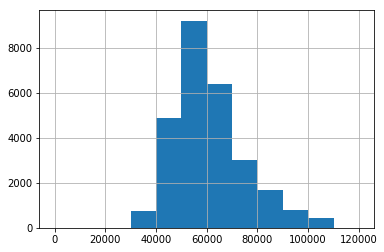

In [5]:
bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

(allDataFrame['price']/allDataFrame['total_square']).hist(bins=bins)
